In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp -r /gdrive/*/Thesis_2/april_data/* .

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Ingesting records

In [ ]:
# the records table as produced by the MATLAB script
all_records = pd.read_csv('records.csv')
# if patients were processed in batches, need to merge tables, like so:
# record_tables = []
# for table_path in os.listdir('record_tables'):
#  tables.append(pd.read_csv(os.path.join('record_tables',table_path)))
# all_records = pd.concat(tables)

all_records['Sex'] = all_records['Sex'].apply(lambda x: x.upper())
all_records['Sex'] = all_records['Sex'].replace({'W': 'F', 'V' : 'F'})
print(all_records['Sex'].value_counts())
all_records['Weight'] = all_records['Weight'].replace({0 : np.nan})
all_records['Height'] = all_records['Height'].replace({0 : np.nan})
all_records['Side'] = all_records['Side'].replace({'-' : ''})
all_records['RecordingDate'] = pd.to_datetime(all_records['RecordingDate'])

def delete_implausible_age(x):
  if (x < 0) | (x > 120):
    return np.nan
  return x

all_records['Age'] = all_records['Age'].apply(delete_implausible_age)

def delete_implausible_weight(x):
  if (x < 0) | (x > 200):
    return np.nan
  return x

all_records['Weight'] = all_records['Weight'].apply(delete_implausible_weight)

def sanitize_height(x):
  # some heights are given as meters rather than cm
  # as nobody is 2.5 cm and nobody taller than 2.5 m, this should work
  if x < 2.5:
    return x * 100
  return x 
all_records['Height'] = all_records['Height'].apply(sanitize_height)

def delete_dummy_heights(x):
  # some all_records have 100 and 100 for height and weight, 
  # this is probably a missing value in reality
  if x['Weight'] == 100.0 and x['Height'] == 100.0:
    x['Height'] = np.nan
    x['Weight'] = np.nan
  return x

def swap_height_and_weight(x):
  # some all_records seem to have height and weight swapped
  if x['Weight'] > x['Height'] and x['Height'] < 150 and x['Weight'] > 100:
    w = x['Height']
    x['Height'] = x['Weight']
    x['Weight'] = w
  return x

all_records = all_records.apply(delete_dummy_heights, axis=1)
all_records = all_records.apply(swap_height_and_weight, axis=1)

all_records['BMI'] = all_records['Weight'] / np.square(all_records['Height'] / 100)

all_records.head()


print(all_records['DeviceInfo'].value_counts())

all_records.describe()

In [0]:
# inspecting a particular patient
all_records[all_records['pid'] == '1176803']

,pid,Height,Weight,Sex,Age,RecordingDate,Side,rid,Class,DeviceInfo,NumberImages,NumberMuscles,Muscles,Sides,EIs,EIZ,BMI
928,1176803,98.0,15.2,M,3.65229,2016-12-01,Links,1176803.20160112.1045,NaN,ESAOTE_6100,20,5,Biceps brachii&Flexor carpi radialis&Gastrocne...,L&R&R&L&R,68&68&74&88&88,2.6423&2.4972&1.6234&2.4564&2.5851,15.826739
929,1176803,103.0,16.4,M,4.50376,2016-11-18,Links,1176803.20161118.0915,NaN,ESAOTE_6100,20,5,Biceps brachii&Flexor carpi radialis&Gastrocne...,L&R&R&L&R,58&52&68&68&66,0.46129&0.044758&0.92816&0.5625&0.65526,15.458573


In [0]:
import seaborn as sns

#sns.scatterplot(data=all_records,x='RecordingDate', y='NumberMuscles', hue='DeviceInfo', size='NumberImages')
all_records['selected'] = (all_records['NumberMuscles'] > 4).astype(str)
px.scatter(all_records,x='RecordingDate', y='NumberMuscles', color='selected', symbol='DeviceInfo')

In [0]:
# records to exclude
# 0531861.20120719.1300: duplicate on the same day, pid in verslag differs, probably operator mistake
# 1182657.20160218.1430: this is actually a diafragma echo, the results don't align with the images at all
# 1921465.20100624.1615: looks to be an inexact duplicate on an older record, image date and report date don't match
# 7605394.20090818.0830: the verslag states that this recording contains errors

records_to_exclude = ['0531861.20120719.1300', '1182657.20160218.1430', '1921465.20100624.1615', '7605394.20090818.0830']
all_records = all_records[~all_records['rid'].isin(records_to_exclude)]

all_records[(all_records.duplicated(['pid', 'RecordingDate'],keep=False))]

,pid,Height,Weight,Sex,Age,RecordingDate,Side,rid,Class,DeviceInfo,NumberImages,NumberMuscles,Muscles,Sides,EIs,EIZ,BMI,selected
885,1156681,189.0,101.0,M,50.7023,2018-04-24,Links,1156681_201804241311,NMD,ESAOTE_6100,40,5,Biceps brachii&Biceps brachii&Rectus abdominis...,L&R&L&R&L&R&L&R&L&R,70&64&57&65&69&58&73&73&119&130,-0.3&-1.1&-1.9&-1.3&0.5&-0.9&-0.2&-0.2&6.7&8,28.274684,True
886,1156681,189.0,101.0,M,50.7023,2018-04-24,Links,1156681_201804241331,NMD,ESAOTE_6100,6,1,Depressor anguli oris&Depressor anguli oris,L&R,40&43,-0.3&-0.1,28.274684,False
1543,1412405,169.0,78.0,F,49.1937,2018-10-08,Rechts,1412405_201808100959,NMD,ESAOTE_6100,8,1,Vastus lateralis&Vastus lateralis,L&R,109&77,4.3&0.8,27.309968,False
1544,1412405,169.0,78.0,F,49.1937,2018-10-08,Rechts,1412405_201808100927,NMD,ESAOTE_6100,15,2,Rectus abdominis&Rectus abdominis&Sterno cleid...,L&R&L&R,86&97&87&76,0.1&0.9&5.5&3.2,27.309968,False
1545,1412405,169.0,78.0,F,49.1937,2018-10-08,Rechts,1412405_201808100839,NMD,ESAOTE_6100,61,6,Biceps brachii&Biceps brachii&Deltoideus&Delto...,L&R&L&R&L&R&L&R&L&R&L&R,87&93&86&86&89&86&97&89&72&74&97&110,2.5&3.3&2.7&2.7&4.8&4.4&4&3.1&0&0.2&1.8&3.2,27.309968,True
1690,1466743,180.0,82.0,M,79.3320,2019-03-28,,1466743_201903281353,NMD,ESAOTE_6100,19,5,Biceps brachii&Digastricus&Flexor carpi radial...,R&R&R&R&R,85&38&93&66&71,0.5&-1.7&5.7&-1.2&-1.1,25.308642,True
1691,1466743,180.0,82.0,M,79.3320,2019-03-28,,1466743_201903281411,NMD,ESAOTE_6100,63,11,Biceps brachii&Digastricus&Flexor carpi radial...,L&L&L&L&R&R&L&L&R&L&R&L&L&R&L&R,85&40&83&119&89&79&68&126&128&93&94&63&109&113...,0.5&-1.4&4.2&5.3&1.6&3.6&-1.1&2.1&2.2&3.3&3.4&...,25.308642,True
3475,5889298,173.0,85.0,M,70.7023,2013-10-15,,5889298.20131015.1300,NaN,Philips Medical Systems_iU22,47,6,Biceps brachii&Biceps brachii&Extensor digitor...,R&L&R&L&R&L&R&L&R&L&R&L,54&69&35&23&49&41&44&47&33&25&46&51,2.2442&4.1182&-0.7037&-2.1962&2.5664&1.238&1.0...,28.400548,True
3476,5889298,173.0,85.0,M,70.7023,2013-10-15,,5889298.20131025.0930,NaN,Philips Medical Systems_iU22,6,1,Peroneus longus&Peroneus longus,R&L,51&80,NaN&NaN,28.400548,False
4785,8912944,173.0,62.0,M,49.5332,2018-03-04,Rechts,8912944_201804031102,NMD,ESAOTE_6100,7,1,Depressor anguli oris&Depressor anguli oris,L&R,48&42,-0.3&-0.9,20.715694,False


In [0]:
def merge_records(all_records,to_merge_in, to_keep):
  keep_index = all_records.index[all_records['rid'] == to_keep].tolist()[0]
  merge_index = all_records.index[all_records['rid'] == to_merge_in].tolist()[0]
  all_records.at[keep_index, 'Muscles'] = '&'.join([all_records.loc[keep_index]['Muscles'],all_records.loc[merge_index]['Muscles']])
  all_records.at[keep_index, 'EIs'] = '&'.join([all_records.loc[keep_index]['EIs'],all_records.loc[merge_index]['EIs']])
  all_records.at[keep_index, 'EIZ'] = '&'.join([all_records.loc[keep_index]['EIZ'],all_records.loc[merge_index]['EIZ']])
  all_records.at[keep_index, 'NumberImages'] = all_records.loc[keep_index]['NumberImages'] + all_records.loc[merge_index]['NumberImages']
  all_records.at[keep_index, 'NumberMuscles'] = all_records.loc[keep_index]['NumberMuscles'] + all_records.loc[merge_index]['NumberMuscles']
  all_records.drop(index=[merge_index],inplace=True)

In [0]:
# merge records taken on the same day
merger_same_day = {'1156681_201804241331': '1156681_201804241311', '1412405_201808100959': '1412405_201808100839',
            '1412405_201808100927': '1412405_201808100839', '1466743_201903281353': '1466743_201903281411',
            '5889298.20131025.0930': '5889298.20131015.1300','8912944_201804031102': '8912944_201804031132'}

merger_close_no_overlap = {'1219623.20160701.1015': '1219623.20160623.0930', '6623641.20161209.1000': '6623641.20160923.0930'}
merger = {**merger_same_day, **merger_close_no_overlap}
for to_merge, to_keep in merger.items():
  merge_records(all_records, to_merge,to_keep)

all_records[(all_records.duplicated(['pid', 'RecordingDate'],keep=False))]


,pid,Height,Weight,Sex,Age,RecordingDate,Side,rid,Class,DeviceInfo,NumberImages,NumberMuscles,Muscles,Sides,EIs,EIZ,BMI,selected


In [0]:
all_records.reset_index(inplace=True)

In [0]:
counts = all_records['pid'].value_counts().to_dict()
all_records['p_count'] = all_records['pid'].apply(lambda x: counts[x])

In [0]:
all_records['is_multi'] = (all_records['p_count'] > 2).astype(bool)
px.scatter(all_records,x='RecordingDate', y='NumberMuscles', color='is_multi', hover_data=['Muscles'])

In [0]:
sum(all_records['is_multi'])

702

In [0]:
import re

part_replacements = {'Flex': 'Flexor','Tib' : 'Tibialis', 'Tib.' : 'Tibialis',
                'kop': 'head', 'laterale': 'lateral', 'mediale': 'medial',
                'med': 'medial',
                'Bic': 'Biceps', 'Delt': 'Deltoideus', 'Ext': 'Extensor',
                'Gastr' : 'Gastrocnemius', 'Gastrocn': 'Gastrocnemius', 'magn': 'magnus',
                'long': 'longus', 'hall': 'hallucis', 'cervicaal' : 'cervical',
                'lumbaal': 'lumbal', 'thoracaal': 'thoracal', 'paraspinaal': 'paraspinal',
                'li': '', 're': '', 'atrofie': '', '10cm': '', '15cm': '', '20cm': ''}

full_replacements = {'Ah':'Abductor hallucis', 'Extensoren onderarm': 'Extensors underarm',
                     'Gastrocnemius med': 'Gastrocnemius medial head', 'Edb': 'Extensor digitorum brevis',
                     'Biceps': 'Biceps brachii','Depressor anguli': 'Depressor anguli oris',
                     'Rectabd' : 'Rectus abdominis', 'Gastrocnemius medial' : 'Gastrocnemius medial head',
                     'Gastrocnemius lat' : 'Gastrocnemius lateral head', 'Gastrocnemius lat head':
                     'Gastrocnemius lateral head', 'Gastrmed' : 'Gastrocnemius medial head',
                     'Gasrocnemius': 'Gastrocnemius medial head', 'Gastrocnemius': 'Gastrocnemius medial head',
                     'Extensor onderarm': 'Extensors underarm', 'Flexor onderarm': 'Flexor carpi radialis',
                     'Vastus lat': 'Vastus lateralis','Vastus medial': 'Vastus medialis',
                     'Interosseus dorsalis 1': 'Interosseus dorsalis I', 'M interosseus dors I':
                     'Interosseus dorsalis I', 'Interosseus dorsalis 1 dh': 'Interosseus dorsalis I',
                     'Finger flexors': 'Flexor digitorum profundus', 'Flexoren onderarm': 'Flexor carpi radialis',
                     'Flex. onderarm': 'Flexor carpi radialis',
                     'Fhl': 'Flexor hallucis longus'}

debatable_cases = {'Rectus femoris prox (fshd)': 'Rectus femoris prox', 'Vastus lateralis prox (fshd)': 'Vastus lateralis prox'}

full_replacements = {**full_replacements, **debatable_cases}
all_rules_applied = {};

def sanitize_muscle_name(x):
  # first split into component parts
  parts = re.split('_| ', x)
  # capitalize the first component
  parts[0] = parts[0].capitalize()
  # all other components need to be lowercase
  for i in range(0,len(parts)):
    if i >= 1 and parts[i] != 'I':
      parts[i] = parts[i].lower()
    if parts[i] in part_replacements:
      if parts[i]:
        parts[i] = part_replacements[parts[i]]
  
  parts = [part for part in parts if part != '']
  merged_string = ' '.join(parts)
  if merged_string in full_replacements:
      merged_string = full_replacements[merged_string]
  if x not in all_rules_applied:
    all_rules_applied[x] = merged_string
  return merged_string

In [0]:
all_records['Muscles'] = all_records['Muscles'].apply(lambda x: x.split('&'))
all_records['Sides'] = all_records['Sides'].apply(lambda x: x.split('&'))
all_records['EIs'] = all_records['EIs'].apply(lambda x: x.split('&') if isinstance(x,str) else x)
all_records['EIZ'] = all_records['EIZ'].apply(lambda x: x.split('&') if isinstance(x,str) else x)

all_records['EIs'] = all_records['EIs'].apply(lambda y: [int(elem) if elem != 'NaN' else np.nan for elem in y])
all_records['EIZ'] = all_records['EIZ'].apply(lambda y: [float(elem) if elem != 'NaN' else np.nan for elem in y])


In [0]:
all_records['Muscles'] = all_records['Muscles'].apply(lambda y: [sanitize_muscle_name(x) for x in y])
# retain the list
all_records['Muscles_list'] = all_records['Muscles']
# enforce uniqueness
all_records['Muscles'] = all_records['Muscles'].apply(lambda y:set(y))
# count the number of unique muscles
all_records['NumberMuscles'] = all_records['Muscles'].apply(lambda y: len(y))

In [0]:
# number of muscles before
print(len(set(all_rules_applied.keys())))

121


In [0]:
# number of muscles after
print(len(set(all_rules_applied.values())))

65


In [0]:
print(all_rules_applied)

{'Biceps brachii': 'Biceps brachii', 'Deltoideus': 'Deltoideus', 'Flexor carpi radialis': 'Flexor carpi radialis', 'Flexor digitorum profundus': 'Flexor digitorum profundus', 'Gastrocnemius medial head': 'Gastrocnemius medial head', 'Tibialis anterior': 'Tibialis anterior', 'Vastus lateralis': 'Vastus lateralis', 'Digastricus': 'Digastricus', 'Geniohyoideus': 'Geniohyoideus', 'Interosseus dorsalis I': 'Interosseus dorsalis I', 'Masseter': 'Masseter', 'Rectus abdominis': 'Rectus abdominis', 'Rectus femoris': 'Rectus femoris', 'Sterno cleido': 'Sterno cleido', 'Trapezius': 'Trapezius', 'Biceps': 'Biceps brachii', 'Flex_onderarm': 'Flexor carpi radialis', 'Quadriceps': 'Quadriceps', 'Tib_anterior': 'Tibialis anterior', 'Sterno_cleido': 'Sterno cleido', 'Peroneus tertius': 'Peroneus tertius', 'Flexoren onderarm': 'Flexor carpi radialis', 'Gastrocnemius mediale kop': 'Gastrocnemius medial head', 'Mentalis': 'Mentalis', 'Orbicularis oris': 'Orbicularis oris', 'Temporalis': 'Temporalis', 'Zyg

In [0]:
#tester = pd.DataFrame.from_records(all_rules_applied)
tester = pd.Series(all_rules_applied).to_frame()
tester = tester.reset_index()
tester.rename(columns={'index': 'original', 0:'new'}, inplace=True)
tester['changed'] = tester['original'] != tester['new']
tester.head()
tester.to_excel('Muscle_names.xlsx')

In [0]:
# classify each muscle record as to what type of muscles it has
child = ['Biceps brachii' , 'Flexor carpi radialis', 'Vastus lateralis', 'Tibialis anterior', 'Gastrocnemius medial head']

adult = ['Deltoideus', 'Biceps brachii' , 'Flexor carpi radialis', 'Interosseus dorsalis I', 'Vastus lateralis', 'Tibialis anterior', 'Gastrocnemius medial head', 'Peroneus tertius']
myositis = ['Deltoideus', 'Biceps brachii' , 'Flexor carpi radialis', 'Flexor digitorum profundus', 'Vastus lateralis', 'Tibialis anterior', 'Gastrocnemius medial head']
als = ['Digastricus', 'Geniohyoideus', 'Masseter', 'Sterno cleido', 'Trapezius', 'Biceps brachii' , 'Flexor carpi radialis', 'Interosseus dorsalis I', 'Rectus abdominis', 'Rectus femoris', 'Tibialis anterior', 'Gastrocnemius medial head']
class_dict = {'Adult': set(adult), 'Child': set(child), 'Myositis': set(myositis), 'ALS': set(als)}

def classify_muscle_record(muscle_list):
  muscle_set = set(muscle_list)

  superset_matches = []
  subset_matches = []
  for k, v in class_dict.items():
    if muscle_set == v: return k
    elif muscle_set.issuperset(v): superset_matches.append(k)
    elif muscle_set.issubset(v): subset_matches.append(k)

  if superset_matches:
    return 'Superset'
  
  if subset_matches:
    return 'Subset'

  return 'Custom'


In [0]:
all_records['RecordType'] = all_records['Muscles'].apply(classify_muscle_record)
all_records['RecordType'].value_counts()

Custom      1772
Subset      1377
Superset     854
Adult        506
ALS          421
Myositis     245
Child        150
Name: RecordType, dtype: int64

In [0]:
#sorted_recs = all_records.sort_values(by=['RecordingDate'])
# encode muscle presence as one-hot
binary_muscle_pres = pd.get_dummies(pd.DataFrame(all_records.Muscles.tolist()).stack()).astype(bool).max(level=0)
binary_muscle_pres.head()

,Abductor digiti minimi,Abductor hallucis,Adductor brevis,Adductor magnus,Biceps brachii,Biceps femoris,Biceps lat,Brachioradialis,Deltoideus,Deltoideus prox,Depressor anguli oris,Diafragma,Digastricus,Extensor digitorum brevis,Extensor digitorum longus,Extensor hallucis brevis,Extensor hallucis longus,Extensors underarm,Flexor carpi radialis,Flexor digitorum profundus,Flexor hallucis longus,Gastrocnemius lateral head,Gastrocnemius medial head,Geniohyoideus,Gluteus maximus,Gluteus medius,Hamstrings,Iliopsoas,Infraspinatus,Intercostals,Interosseus dorsalis I,Levator labii superior,Lingualis,Masseter,Mentalis,Nasalis,Obliquus ext. abdominus,Obliquus int. abdominus,Orbicularis oris,Other,Paraspinaal cervical,Paraspinaal l4,Paraspinaal lumbal,Paraspinaal thoracal,Peroneus longus,Peroneus tertius,Procerus,Quadriceps,Rectus abdominis,Rectus femoris,Rectus femoris prox,Soleus,Sterno cleido,Supraspinatus,Temporalis,Tibialis anterior,Tongue,Transversus abdominus,Trapezius,Triceps,Vastus lateralis,Vastus lateralis dist,Vastus lateralis prox,Vastus medialis,Zygomaticus major
0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


In [0]:
all_records.loc[0]['Muscles']

{'Biceps brachii',
 'Deltoideus',
 'Flexor carpi radialis',
 'Flexor digitorum profundus',
 'Gastrocnemius medial head',
 'Tibialis anterior',
 'Vastus lateralis'}

In [0]:
all_records.Muscles.tolist()[0]

{'Biceps brachii',
 'Deltoideus',
 'Flexor carpi radialis',
 'Flexor digitorum profundus',
 'Gastrocnemius medial head',
 'Tibialis anterior',
 'Vastus lateralis'}

In [0]:
for i in range(0,5000):
  aal = (all_records.loc[i]['Muscles'] == all_records.Muscles.tolist()[i])
  if not all:
    print(i)

In [0]:
binary_muscle_pres2 = pd.get_dummies(pd.DataFrame(all_records.Muscles.tolist()).stack()).astype(bool)
aal = pd.DataFrame(all_records.Muscles.tolist()).stack()
print(aal.loc[551])
print(aal.loc[552])
aal.loc[551] == aal.loc[552]

0              Rectus abdominis
1                Biceps brachii
2     Gastrocnemius medial head
3         Flexor carpi radialis
4                Rectus femoris
5                     Trapezius
6             Tibialis anterior
7                 Sterno cleido
8                 Geniohyoideus
9                   Digastricus
10       Interosseus dorsalis I
11                     Masseter
dtype: object
0              Rectus abdominis
1     Gastrocnemius medial head
2                Biceps brachii
3                Rectus femoris
4                     Trapezius
5         Flexor carpi radialis
6             Tibialis anterior
7                 Sterno cleido
8                 Geniohyoideus
9                   Digastricus
10       Interosseus dorsalis I
11                     Masseter
dtype: object


0      True
1     False
2     False
3     False
4     False
5     False
6      True
7      True
8      True
9      True
10     True
11     True
dtype: bool

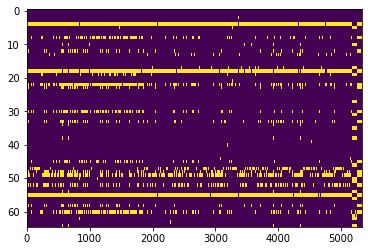

In [0]:
mat = binary_muscle_pres.to_numpy()
plt.imshow(np.transpose(mat),interpolation='nearest', aspect='auto')

404


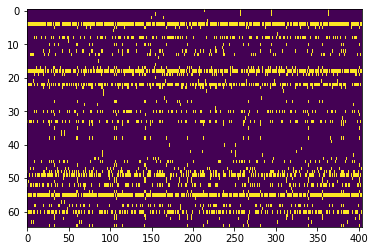

In [0]:
# how many combinations of scanned muscles are there
unique_rows = np.vstack(list({tuple(row) for row in mat}))
print(unique_rows.shape[0])
plt.imshow(np.transpose(unique_rows),interpolation='nearest', aspect='auto')
combs = [tuple(row) for row in mat]

from collections import Counter
c = Counter(combs)

In [0]:
# for each record, find which type it is
record_combs = []
for row in mat:
  index = np.where((row==unique_rows).all(axis=1))[0][0]
  record_combs.append(index)

In [0]:
print(all_records.loc[551]['Muscles'])
print(binary_muscle_pres.loc[551]['Rectus abdominis'])

{'Rectus abdominis', 'Biceps brachii', 'Gastrocnemius medial head', 'Flexor carpi radialis', 'Rectus femoris', 'Trapezius', 'Tibialis anterior', 'Sterno cleido', 'Geniohyoideus', 'Digastricus', 'Interosseus dorsalis I', 'Masseter'}
True


In [0]:
print(all_records.loc[552]['Muscles'])
print(binary_muscle_pres.loc[552]['Rectus abdominis'])

{'Rectus abdominis', 'Gastrocnemius medial head', 'Biceps brachii', 'Rectus femoris', 'Trapezius', 'Flexor carpi radialis', 'Tibialis anterior', 'Sterno cleido', 'Geniohyoideus', 'Digastricus', 'Interosseus dorsalis I', 'Masseter'}
True


In [0]:
# add the record type id for each record
all_records['RecordTypeId'] = pd.Series(record_combs)
# add a count of how prevalent this type of record is
all_records['RecordTypeIdCount'] = all_records['RecordTypeId'].map(all_records['RecordTypeId'].value_counts())

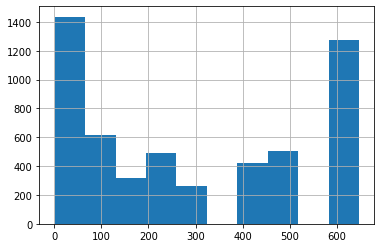

In [0]:
all_records['RecordTypeIdCount'].hist()

In [0]:
all_records[all_records['RecordType'] == 'Custom']['RecordTypeId'].value_counts()

315    625
100    262
299    101
113     67
321     66
      ... 
330      1
214      1
327      1
217      1
212      1
Name: RecordTypeId, Length: 203, dtype: int64

In [0]:
all_records[all_records['RecordTypeId'] == 327].iloc[0]['Muscles']

{'Deltoideus', 'Trapezius'}

In [0]:
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

def process_record_scores(record):
  #if not isinstance(record['EIs'], list) or not isinstance(record['EIZ'], list):
  #  return np.nan
  #df = pd.DataFrame(list(zip(record['Muscles'], record['Sides'],record['EIs'],record['EIZ'])), 
  #             columns =['Muscle', 'Side', 'EI', 'EI_zscore']) 
  
  z_scores = pd.Series(record['EIZ']).astype(float)
  if z_scores.isnull().all():
    return record
  # count the total number of non-null z-scores
  z_scores = z_scores[~z_scores.isnull()]

  record['NumberZscores'] = len(z_scores)
  
  for t in thresholds:
    count = sum(z_scores > t)
    name = 'Z_exceed' + str(t)
    record[name] = count

  return record
  
# aggregate into feature representation
all_records = all_records.apply(process_record_scores, axis=1)

In [0]:
all_records.head()

,Age,BMI,Class,DeviceInfo,EIZ,EIs,Height,Muscles,Muscles_list,NumberImages,NumberMuscles,NumberZscores,RecordType,RecordTypeId,RecordTypeIdCount,RecordingDate,Sex,Side,Sides,Weight,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,index,is_multi,p_count,pid,rid,selected
0,52.2546,27.398176,NaN,ESAOTE_6100,"[-1.2, -0.7, 0.7, -0.4, -0.2, -0.8, -1.3, -1.7...","[62, 66, 66, 58, 49, 45, 50, 47, 49, 45, 82, 6...",173.0,"{Biceps brachii, Gastrocnemius medial head, Fl...","[Biceps brachii, Biceps brachii, Deltoideus, D...",56,7,14.0,Myositis,349,245,2019-04-23,M,Rechts,"[L, R, L, R, L, R, L, R, L, R, L, R, L, R]",82.0,1.0,1.0,0.0,0.0,0.0,0.0,0,False,1,0004502,0004502_201904231056,True
1,60.2793,26.592670,NaN,ESAOTE_6100,"[-0.39546, -0.27024, 2.9545, 1.9964, -0.55423,...","[69, 70, 73, 65, 48, 53, 69, 58, 44, 47, 45, 7...",186.0,"{Rectus abdominis, Biceps brachii, Gastrocnemi...","[Biceps brachii, Biceps brachii, Digastricus, ...",90,12,23.0,ALS,68,421,2016-02-26,M,Links,"[L, R, L, R, L, R, L, R, L, L, R, L, R, L, R, ...",92.0,3.0,2.0,1.0,1.0,0.0,0.0,1,False,2,0006930,0006930.20160226.0830,True
2,53.9822,27.026246,NaN,Philips Medical Systems_iU22,"[1.7, 1.5, 0.2, 0.1, -1.0, 0.1, 0.0, 0.8]","[43, 41, 29, 28, 20, 29, 36, 43]",186.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Biceps brachii, Flexor carpi ...",31,4,8.0,Custom,315,625,2009-09-11,M,,"[R, L, R, L, R, L, R, L]",93.5,2.0,1.0,0.0,0.0,0.0,0.0,2,False,2,0006930,0006930.20091109.0930,False
3,66.6420,29.617289,no NMD,ESAOTE_6100,"[-1.5202, -2.8851, -1.1296, -0.49187, -0.18478...","[61, 52, 63, 72, 55, 55, 63, 60, 71, 75, 73, 7...",147.0,"{Rectus abdominis, Biceps brachii, Gastrocnemi...","[Biceps brachii, Biceps brachii, Deltoideus, D...",114,15,27.0,Superset,228,1,2017-10-11,F,Rechts,"[L, R, L, R, L, R, L, R, L, R, L, R, L, L, R, ...",64.0,4.0,3.0,1.0,1.0,0.0,0.0,3,False,1,0007036,0007036.20171110.0900,True
4,69.9083,23.449341,NaN,ESAOTE_6100,"[-1.3, -1.4, 1.4, -0.3, -0.5, 0.3, 0.2, 0.8, 4...","[68, 67, 76, 63, 50, 56, 74, 79, 105, 119, 91,...",187.0,"{Biceps brachii, Gastrocnemius medial head, Fl...","[Biceps brachii, Biceps brachii, Deltoideus, D...",64,8,16.0,Superset,397,55,2018-09-20,M,Rechts,"[L, R, L, R, L, R, L, R, L, R, L, R, L, R, L, R]",82.0,8.0,5.0,4.0,4.0,4.0,3.0,4,False,1,0008191,0008191_201809201006,True


In [0]:
def predict_rule_based(x):
  if np.isnan(x['NumberZscores']):
    return np.nan
  # age below 65
  if x['Age'] < 65:
    # fewer than six z-scores recorded
    if x['NumberZscores'] < 6:
      # one muscle exceeds 3.5
      if x['Z_exceed3.5'] >= 1:
        return 'NMD'
      # two muscles exceed 2.5
      if x['Z_exceed2.5'] >= 2:
        return 'NMD'
      # three exceed 1.5
      if x['Z_exceed1.5'] >= 3:
        return 'NMD'
      # one muscle exceeds 2.0
      if x['Z_exceed2.0'] >= 1:
        return 'unknown or uncertain'
      # two muscles exceeds 1.5
      if x['Z_exceed1.5'] >= 2:
        return 'unknown or uncertain'
      # three exceed 1.0
      if x['Z_exceed1.0'] >= 3:
        return 'unknown or uncertain'
      # basecase
      return 'no NMD'
      
    # six or more z-scores
    else:
      # one muscle exceeds 3.5
      if x['Z_exceed3.5'] >= 1:
        return 'NMD'
      # two muscles exceed 2.5
      if x['Z_exceed2.5'] >= 2:
        return 'NMD'
      # three exceed 1.5
      if x['Z_exceed1.5'] >= 3:
        return 'NMD'
      # one muscle exceeds 2.0
      if x['Z_exceed2.0'] >= 1:
        return 'unknown or uncertain'
      # basecase
      return 'no NMD'

  # age above 65
  else:
    # fewer than six z-scores
    if x['NumberZscores'] < 6:
      # one muscle exceeds 3.5
      if x['Z_exceed3.5'] >= 1:
        return 'NMD'
      # two muscles exceed 2.5
      if x['Z_exceed2.5'] >= 2:
        return 'NMD'
      # three exceed 1.5
      if x['Z_exceed1.5'] >= 3:
        return 'NMD'
      # *one muscle exceeds 2.5*
      if x['Z_exceed2.5'] >= 1:
        return 'unknown or uncertain'
      # basecase
      return 'no NMD'
      
    # six or more z-scores
    else:
      # one muscle exceeds 3.5
      if x['Z_exceed3.5'] >= 1:
        return 'NMD'
      # two muscles exceed 2.5
      if x['Z_exceed2.5'] >= 2:
        return 'NMD'
      # *three exceed 2.0*
      if x['Z_exceed2.0'] >= 3:
        return 'NMD'
      # *one muscle exceeds 3.0*
      if x['Z_exceed3.0'] >= 1:
        return 'unknown or uncertain'
      # basecase
      return 'no NMD'

In [0]:
all_records['RuleBasedLabel'] = all_records.apply(predict_rule_based, axis=1)
print(all_records['RuleBasedLabel'].value_counts())
#all_records['NumberZscores'].hist()
len(all_records)

no NMD                  2620
NMD                     2052
unknown or uncertain     648
Name: RuleBasedLabel, dtype: int64


5325

## Aggregating to patient level

In [0]:
print(all_records.columns)
def merge_lists(lists):
  base = []
  for e in lists:
    base.extend(e)
  return base

def is_unique(s):
    s = s.dropna()
    if len(s) == 0: return ''
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a[1:]).all()

def simple_merge(infos):
  if is_unique(infos):
    return str(infos.values[0])
  else:
    return 'Multiple'

def get_date_diff(timeranges):
  if len(timeranges) < 2:
    return np.array([0])
  sorted_range = np.sort(timeranges)[::-1]
  diffs = np.abs(np.diff(sorted_range))   
  diffs = [diff.astype('timedelta64[D]') / np.timedelta64(1, 'D') for diff in diffs]
  return diffs

def check_if_muscles_overlap(muscle_lists):
  if(len(muscle_lists) < 2): return False
  overlaps = []
  for i, set_a in enumerate(muscle_lists):
    for j, set_b in enumerate(muscle_lists):
      # don't check overlap within
      if i == j: continue
      if len(set_a.intersection(set_b)) > 1:
        return True
  return False


agg_dict = {'Muscles' : merge_lists, 'Height': max, 'Weight': max, 'Sex': max,
            'Age': max,
            'Side': max, 'Class': max, 'NumberImages': sum, 'NumberZscores' : sum,
            'BMI': max, 'DeviceInfo': simple_merge,
            'RecordType': simple_merge, 'RuleBasedLabel': simple_merge,'RecordTypeId': simple_merge}

for t in thresholds:
   name = 'Z_exceed' + str(t)
   agg_dict[name] = sum

patients = all_records.groupby('pid').agg(agg_dict)
patients['NumberMuscles'] = patients['Muscles'].apply(lambda y: len(set(y)))
patients['NumberRecords'] = all_records.groupby('pid').size()
date_frame = all_records.groupby('pid').agg(FirstRecording=pd.NamedAgg(column='RecordingDate', aggfunc='min'),
                                            LastRecording=pd.NamedAgg(column='RecordingDate', aggfunc='max'))
patients = patients.join(date_frame)

date_frame = all_records.groupby('pid').agg(AgeAtFirst=pd.NamedAgg(column='Age', aggfunc='min'),
                                            AgeAtLast=pd.NamedAgg(column='Age', aggfunc='max'))

patients = patients.join(date_frame)

date_frame = all_records.groupby('pid').agg(MeanDateDiff=pd.NamedAgg(column='RecordingDate', aggfunc=lambda x : np.mean(get_date_diff(x))),
                                            VarDateDiff=pd.NamedAgg(column='RecordingDate', aggfunc=lambda x : np.var(get_date_diff(x))),
                                            MusclesInRecordsOverlap=pd.NamedAgg('Muscles',aggfunc=lambda x: check_if_muscles_overlap(x)))

patients = patients.join(date_frame)

patients['TimeRange'] = patients['LastRecording'] - patients['FirstRecording'];
patients = patients.reset_index()
patients.head()


Index(['Age', 'BMI', 'Class', 'DeviceInfo', 'EIZ', 'EIs', 'Height', 'Muscles',
       'Muscles_list', 'NumberImages', 'NumberMuscles', 'NumberZscores',
       'RecordType', 'RecordTypeId', 'RecordTypeIdCount', 'RecordingDate',
       'Sex', 'Side', 'Sides', 'Weight', 'Z_exceed1.0', 'Z_exceed1.5',
       'Z_exceed2.0', 'Z_exceed2.5', 'Z_exceed3.0', 'Z_exceed3.5', 'index',
       'is_multi', 'p_count', 'pid', 'rid', 'selected', 'RuleBasedLabel'],
      dtype='object')


,pid,Muscles,Height,Weight,Sex,Age,Side,Class,NumberImages,NumberZscores,BMI,DeviceInfo,RecordType,RuleBasedLabel,RecordTypeId,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,NumberMuscles,NumberRecords,FirstRecording,LastRecording,AgeAtFirst,AgeAtLast,MeanDateDiff,VarDateDiff,MusclesInRecordsOverlap,TimeRange
0,0004502,"[Biceps brachii, Gastrocnemius medial head, Fl...",173.0,82.0,M,52.2546,Rechts,NaN,56,14.0,27.398176,ESAOTE_6100,Myositis,no NMD,349,1.0,1.0,0.0,0.0,0.0,0.0,7,1,2019-04-23,2019-04-23,52.2546,52.2546,0.0,0.0,False,0 days
1,0006930,"[Rectus abdominis, Biceps brachii, Gastrocnemi...",186.0,93.5,M,60.2793,Links,NaN,121,31.0,27.026246,Multiple,Multiple,Multiple,Multiple,5.0,3.0,1.0,1.0,0.0,0.0,13,2,2009-09-11,2016-02-26,53.9822,60.2793,2359.0,0.0,True,2359 days
2,0007036,"[Rectus abdominis, Biceps brachii, Gastrocnemi...",147.0,64.0,F,66.6420,Rechts,no NMD,114,27.0,29.617289,ESAOTE_6100,Superset,no NMD,228,4.0,3.0,1.0,1.0,0.0,0.0,15,1,2017-10-11,2017-10-11,66.6420,66.6420,0.0,0.0,False,0 days
3,0008191,"[Biceps brachii, Gastrocnemius medial head, Fl...",187.0,82.0,M,69.9083,Rechts,NaN,64,16.0,23.449341,ESAOTE_6100,Superset,NMD,397,8.0,5.0,4.0,4.0,4.0,3.0,8,1,2018-09-20,2018-09-20,69.9083,69.9083,0.0,0.0,False,0 days
4,0019071,"[Biceps brachii, Flexor carpi radialis, Tibial...",180.0,80.0,M,72.6051,,NaN,18,5.0,24.691358,Philips Medical Systems_iU22,Custom,NMD,100,4.0,3.0,3.0,3.0,2.0,2.0,5,1,2010-07-01,2010-07-01,72.6051,72.6051,0.0,0.0,False,0 days


In [0]:
patients[(patients['NumberRecords'] > 6)]

,pid,Muscles,Height,Weight,Sex,Age,Side,Class,NumberImages,NumberZscores,BMI,DeviceInfo,RecordType,RuleBasedLabel,RecordTypeId,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,NumberMuscles,NumberRecords,FirstRecording,LastRecording,AgeAtFirst,AgeAtLast,MeanDateDiff,VarDateDiff,MusclesInRecordsOverlap,TimeRange
1802,1801036,"[Biceps brachii, Flexor carpi radialis, Rectus...",167.0,61.0,F,16.61330,Rechts,cramp_5.3,249,60.0,24.444444,Multiple,Multiple,Multiple,Multiple,38.0,27.0,17.0,10.0,9.0,8.0,7,7,2012-04-10,2016-01-09,11.95620,16.61330,228.166667,20749.138889,True,1369 days
3068,6098720,"[Biceps brachii, Tibialis anterior, Flexor car...",152.0,63.0,M,12.20810,Links,cramp_5.1,103,28.0,28.452932,Philips Medical Systems_iU22,Multiple,NMD,Multiple,28.0,28.0,28.0,27.0,24.0,23.0,5,7,2007-05-15,2011-02-21,8.43532,12.20810,229.666667,13943.888889,True,1378 days
3111,6294116,"[Biceps brachii, Tibialis anterior, Flexor car...",147.0,55.0,M,11.50440,Rechts,cramp_5.1,126,32.0,25.452358,Philips Medical Systems_iU22,Multiple,NMD,Multiple,30.0,28.0,20.0,11.0,9.0,5.0,5,8,2006-05-15,2011-03-28,6.63655,11.50440,254.000000,13912.857143,True,1778 days
3113,6294779,"[Biceps brachii, Tibialis anterior, Flexor car...",172.0,76.0,F,59.07730,Rechts,NaN,256,64.0,25.689562,Philips Medical Systems_iU22,Multiple,Multiple,Multiple,37.0,29.0,25.0,22.0,14.0,9.0,5,8,2008-09-22,2011-07-15,56.26830,59.07730,146.571429,4627.959184,True,1026 days
3138,6402988,"[Biceps brachii, Tibialis anterior, Flexor car...",157.0,70.0,F,14.91850,Rechts,cramp_5.3,220,54.0,29.864958,Multiple,Multiple,NMD,Multiple,51.0,50.0,45.0,36.0,33.0,30.0,5,7,2007-03-22,2016-06-30,5.64271,14.91850,564.666667,174281.888889,True,3388 days
3152,6449017,"[Biceps brachii, Flexor carpi radialis, Tibial...",163.0,40.0,M,14.61460,Links,cramp_1.1,281,63.0,21.085640,Multiple,Multiple,NMD,Multiple,63.0,58.0,51.0,43.0,39.0,29.0,6,7,2008-01-09,2014-04-06,8.29021,14.61460,379.833333,25578.472222,True,2279 days
3909,8636687,"[Biceps brachii, Tibialis anterior, Flexor car...",171.0,102.0,F,16.81310,Rechts,NaN,240,58.0,67.276825,Multiple,Multiple,Multiple,Multiple,23.0,16.0,10.0,4.0,3.0,1.0,7,8,2009-04-06,2016-07-28,9.66461,16.81310,381.428571,145071.673469,True,2670 days
4165,9553461,"[Biceps brachii, Tibialis anterior, Flexor car...",133.0,30.0,M,9.15264,Rechts,cramp_5.1,112,28.0,17.575446,Philips Medical Systems_iU22,Multiple,Multiple,Multiple,21.0,19.0,14.0,12.0,8.0,5.0,5,7,2008-08-25,2011-08-15,5.64545,9.15264,180.833333,18347.805556,True,1085 days


In [0]:
all_records[(all_records['pid'] == '6294116')]

,Age,BMI,Class,DeviceInfo,EIZ,EIs,Height,Muscles,Muscles_list,NumberImages,NumberMuscles,NumberZscores,RecordType,RecordTypeId,RecordTypeIdCount,RecordingDate,Sex,Side,Sides,Weight,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,index,is_multi,p_count,pid,rid,selected,RuleBasedLabel
3573,7.38672,20.118343,cramp_5.1,Philips Medical Systems_iU22,"[4.0, 1.5, 0.6, 2.2]","[72, 53, 39, 61]",130.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",16,4,4.0,Custom,315,625,2007-02-13,M,,"[L, R, R, L]",34.0,3.0,2.0,2.0,1.0,1.0,1.0,3582,True,8,6294116,6294116.20070213.0930,False,NMD
3574,8.51472,21.998218,cramp_5.1,Philips Medical Systems_iU22,"[2.2, 1.6, 0.6, 1.6]","[57, 54, 39, 56]",134.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",16,4,4.0,Custom,315,625,2008-03-31,M,Rechts,"[L, R, R, L]",39.5,3.0,3.0,1.0,0.0,0.0,0.0,3583,True,8,6294116,6294116.20080331.1030,False,NMD
3575,6.63655,18.707483,cramp_5.1,Philips Medical Systems_iU22,"[2.4, 1.8, 2.4, 2.5]","[59, 55, 52, 64]",126.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",16,4,4.0,Custom,315,625,2006-05-15,M,,"[L, R, R, L]",29.7,4.0,4.0,3.0,0.0,0.0,0.0,3584,True,8,6294116,6294116.20060515.1030,False,NMD
3576,9.31964,24.154589,cramp_5.1,Philips Medical Systems_iU22,"[4.5, 2.1, 3.5, 2.0]","[75, 57, 60, 60]",138.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",16,4,4.0,Custom,315,625,2009-01-19,M,Rechts,"[L, R, R, L]",46.0,4.0,4.0,3.0,2.0,2.0,1.0,3585,True,8,6294116,6294116.20090119.1030,False,NMD
3577,9.58795,23.808291,cramp_5.1,Philips Medical Systems_iU22,"[3.4, 2.0, 2.9, 2.0]","[67, 56, 56, 60]",139.0,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",14,4,4.0,Custom,315,625,2009-04-27,M,,"[L, R, R, L]",46.0,4.0,4.0,2.0,2.0,1.0,0.0,3586,True,8,6294116,6294116.20090427.1200,False,NMD
3578,10.03420,23.809222,cramp_5.1,Philips Medical Systems_iU22,"[3.2, 1.2, 1.8, 1.6]","[65, 51, 48, 56]",140.5,"{Biceps brachii, Tibialis anterior, Flexor car...","[Biceps brachii, Flexor carpi radialis, Quadri...",16,4,4.0,Custom,315,625,2009-07-10,M,Rechts,"[L, R, R, L]",47.0,4.0,3.0,1.0,1.0,1.0,0.0,3587,True,8,6294116,6294116.20091007.1030,False,NMD
3579,10.48870,25.282410,cramp_5.1,Philips Medical Systems_iU22,"[4.4521, 2.4562, 3.7444, 2.484]","[63, 48, 51, 53]",143.0,"{Biceps brachii, Flexor carpi radialis, Rectus...","[Biceps brachii, Flexor carpi radialis, Rectus...",16,4,4.0,Subset,253,647,2010-03-22,M,Rechts,"[L, R, R, L]",51.7,4.0,4.0,4.0,2.0,2.0,2.0,3588,True,8,6294116,6294116.20100322.1400,False,NMD
3580,11.50440,25.452358,cramp_5.1,Philips Medical Systems_iU22,"[3.3186, 2.9432, 4.0253, 2.484]","[55, 51, 53, 53]",147.0,"{Biceps brachii, Flexor carpi radialis, Rectus...","[Biceps brachii, Flexor carpi radialis, Rectus...",16,4,4.0,Subset,253,647,2011-03-28,M,Rechts,"[L, R, R, L]",55.0,4.0,4.0,4.0,3.0,2.0,1.0,3589,True,8,6294116,6294116.20110328.1400,False,NMD


In [0]:
criterion = (patients['MusclesInRecordsOverlap'] == False) & (patients['MeanDateDiff'] < 365) & (patients['NumberRecords'] > 1) & (patients['DeviceInfo'] != 'Multiple')
print(sum(criterion))
patients[criterion]

0


,pid,Muscles,Height,Weight,Sex,Age,Side,Class,NumberImages,NumberZscores,BMI,DeviceInfo,RecordType,RuleBasedLabel,RecordTypeId,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,NumberMuscles,NumberRecords,FirstRecording,LastRecording,AgeAtFirst,AgeAtLast,MeanDateDiff,VarDateDiff,MusclesInRecordsOverlap,TimeRange


In [0]:
all_records[all_records['pid'] == '6623641']

,Age,BMI,Class,DeviceInfo,EIZ,EIs,Height,Muscles,Muscles_list,NumberImages,NumberMuscles,NumberZscores,RecordType,RecordTypeId,RecordTypeIdCount,RecordingDate,Sex,Side,Sides,Weight,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,index,is_multi,p_count,pid,rid,selected,RuleBasedLabel
3792,8.1232,13.219644,NaN,ESAOTE_6100,"[0.46129, 0.81251, 1.044, -0.47917, 0.65526, -...","[58, 57, 69, 57, 66, 37, 42, 59, 49, 44, 39, 3...",123.0,"{Rectus abdominis, Gastrocnemius medial head, ...","[Biceps brachii, Flexor carpi radialis, Gastro...",61,10,15.0,Superset,364,1,2016-09-23,M,Rechts,"[L, R, R, L, R]",20.0,1.0,0.0,0.0,0.0,0.0,0.0,3801,False,1,6623641,6623641.20160923.0930,True,no NMD


In [0]:
patients['RecordTypeIdCount'] = patients['RecordTypeId'].map(patients['RecordTypeId'].value_counts())

In [0]:
patients[(patients['RecordTypeIdCount'] == 1) & ((patients['RecordType'] == 'Custom') | (patients['RecordType'] == 'Subset'))]

,pid,Muscles,Height,Weight,Sex,Age,Side,Class,NumberImages,NumberZscores,BMI,DeviceInfo,RecordType,RuleBasedLabel,RecordTypeId,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,NumberMuscles,NumberRecords,FirstRecording,LastRecording,AgeAtFirst,AgeAtLast,MeanDateDiff,VarDateDiff,MusclesInRecordsOverlap,TimeRange,RecordTypeIdCount
12,0052301,"[Rectus abdominis, Biceps brachii, Gastrocnemi...",189.0,110.0,M,49.85080,Rechts,cramp_5.1,130,25.0,30.794211,ESAOTE_6100,Custom,NMD,212,14.0,12.0,11.0,7.0,6.0,6.0,14,1,2019-12-30,2019-12-30,49.85080,49.85080,0.0,0.0,False,0 days,1
35,0201691,"[Rectus abdominis, Biceps brachii, Flexor carp...",186.0,72.5,M,41.04860,Rechts,no NMD,53,11.0,20.956180,ESAOTE_6100,Custom,no NMD,123,0.0,0.0,0.0,0.0,0.0,0.0,7,1,2017-06-13,2017-06-13,41.04860,41.04860,0.0,0.0,False,0 days,1
52,0277731,"[Rectus abdominis, Biceps brachii, Gastrocnemi...",190.0,96.0,M,57.88910,Rechts,NaN,116,23.0,26.592798,ESAOTE_6100,Custom,NMD,236,12.0,7.0,7.0,4.0,1.0,1.0,15,1,2019-03-07,2019-03-07,57.88910,57.88910,0.0,0.0,False,0 days,1
83,0424588,"[Gastrocnemius medial head, Biceps brachii, Fl...",175.0,90.0,M,49.94110,Rechts,NaN,56,14.0,29.387755,ESAOTE_6100,Subset,no NMD,119,2.0,1.0,0.0,0.0,0.0,0.0,7,1,2015-10-09,2015-10-09,49.94110,49.94110,0.0,0.0,False,0 days,1
243,0764320,"[Gastrocnemius medial head, Flexor carpi radia...",177.0,79.0,M,51.63310,Rechts,NaN,37,5.0,25.216253,Philips Medical Systems_iU22,Custom,no NMD,220,2.0,0.0,0.0,0.0,0.0,0.0,8,1,2009-10-13,2009-10-13,51.63310,51.63310,0.0,0.0,False,0 days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4399,NWS068,"[Depressor anguli oris, Iliopsoas, Levator lab...",175.0,67.5,M,54.52160,Rechts,control,69,1.0,22.040816,ESAOTE_6100,Custom,no NMD,33,0.0,0.0,0.0,0.0,0.0,0.0,15,1,2017-07-31,2017-07-31,54.52160,54.52160,0.0,0.0,False,0 days,1
4402,NWS071,"[Iliopsoas, Rectus femoris prox, Vastus latera...",79.0,11.5,F,1.21010,,control,27,2.0,18.426534,ESAOTE_6100,Custom,no NMD,320,0.0,0.0,0.0,0.0,0.0,0.0,7,1,2017-04-08,2017-04-08,1.21010,1.21010,0.0,0.0,False,0 days,1
4403,NWS072,"[Depressor anguli oris, Iliopsoas, Rectus femo...",105.0,16.0,M,3.57563,,control,40,2.0,14.512472,ESAOTE_6100,Custom,no NMD,313,0.0,0.0,0.0,0.0,0.0,0.0,8,1,2017-04-08,2017-04-08,3.57563,3.57563,0.0,0.0,False,0 days,1
4405,NWS074,"[Depressor anguli oris, Iliopsoas, Tongue, Rec...",118.0,27.0,F,6.65024,Rechts,control,53,2.0,19.390980,ESAOTE_6100,Custom,no NMD,356,0.0,0.0,0.0,0.0,0.0,0.0,11,1,2017-04-08,2017-04-08,6.65024,6.65024,0.0,0.0,False,0 days,1


In [0]:
# relabel cramp and control to NMD and no NMD respectively

def indicate_source(label):
  if not isinstance(label,str): return np.nan
  if label.startswith('cramp'): return 'cramp'
  if label == 'control': return 'control'
  return 'original'

def relabel(label):
  if not isinstance(label,str): return np.nan
  if label.startswith('cramp'): return 'NMD'
  if label == 'control': return 'no NMD'
  return str(label)
patients['Class_full'] = patients['Class'] 
patients['Source'] = patients['Class'].apply(indicate_source) 
patients['Class'] = patients['Class'].apply(relabel) 

In [0]:
#patients[patients['RuleBasedLabel'] =='nan'].head()
patients.groupby(['Class', 'RuleBasedLabel']).size()

Class                 RuleBasedLabel      
NMD                   Multiple                 62
                      NMD                     558
                      no NMD                  237
                      unknown or uncertain     86
no NMD                Multiple                  8
                      NMD                      19
                      no NMD                  313
                      unknown or uncertain     27
unknown or uncertain  Multiple                  3
                      NMD                      19
                      no NMD                   28
                      unknown or uncertain      3
dtype: int64

In [0]:
labeled_multirecord = patients[(patients['NumberRecords'] == 8) & (~patients['Class'].isnull())]
print(labeled_multirecord['Class'].value_counts())
print(labeled_multirecord['NumberRecords'].value_counts())
labeled_multirecord.head()

NMD    1
Name: Class, dtype: int64
8    1
Name: NumberRecords, dtype: int64


,pid,Muscles,Height,Weight,Sex,Age,Side,Class,NumberImages,NumberZscores,BMI,DeviceInfo,RecordType,RuleBasedLabel,RecordTypeId,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,NumberMuscles,NumberRecords,FirstRecording,LastRecording,AgeAtFirst,AgeAtLast,MeanDateDiff,VarDateDiff,MusclesInRecordsOverlap,TimeRange,RecordTypeIdCount,Class_full,Source
3111,6294116,"[Biceps brachii, Tibialis anterior, Flexor car...",147.0,55.0,M,11.5044,Rechts,NMD,126,32.0,25.452358,Philips Medical Systems_iU22,Multiple,NMD,Multiple,30.0,28.0,20.0,11.0,9.0,5.0,5,8,2006-05-15,2011-03-28,6.63655,11.5044,254.0,13912.857143,True,1778 days,276,cramp_5.1,cramp


In [0]:
corr_matrix = all_records.corr('spearman').abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [0]:
print(sol)

Z_exceed1.0   Z_exceed1.5      0.918829
Z_exceed1.5   Z_exceed2.0      0.917612
Z_exceed2.0   Z_exceed2.5      0.904684
BMI           Weight           0.903875
NumberImages  NumberZscores    0.901640
                                 ...   
RecordTypeId  Z_exceed2.5      0.006067
Z_exceed2.5   index            0.005784
Z_exceed3.0   index            0.005348
Z_exceed2.0   index            0.004903
RecordTypeId  index            0.004525
Length: 153, dtype: float64


In [0]:
# encode muscle presence as one-hot
patients = patients.join(
    pd.get_dummies(
        pd.DataFrame(patients.Muscles.tolist()).stack()
    ).astype(int).sum(level=0)
)
patients = patients.drop(columns='Muscles')

For some patients, we have records from multiple machines, this is potentially quite interesting for purposes of standardization. 

count                           79
mean     1974 days 15:29:37.215189
std      1116 days 16:51:56.405248
min               49 days 00:00:00
25%             1072 days 00:00:00
50%             2005 days 00:00:00
75%             2718 days 00:00:00
max             4437 days 00:00:00
Name: TimeRange, dtype: object
NMD                     27
unknown or uncertain     1
no NMD                   1
Name: Class, dtype: int64


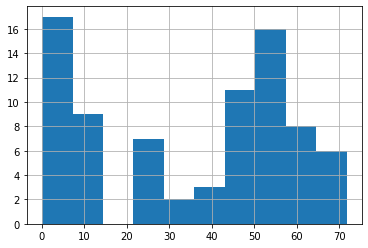

In [0]:
multi_device = patients[patients['DeviceInfo'] == 'Multiple']
print(multi_device['TimeRange'].describe())
multi_device['AgeAtFirst'].hist()
print(multi_device['Class'].value_counts())

In [0]:
patients.describe()
patients.to_excel('all_patients.xlsx')

In [0]:
# encode muscle presence as one-hot
all_records = all_records.drop('Muscles',1).join(
    pd.get_dummies(
        pd.DataFrame(all_records.Muscles.tolist()).stack()
    ).astype(int).sum(level=0)
)

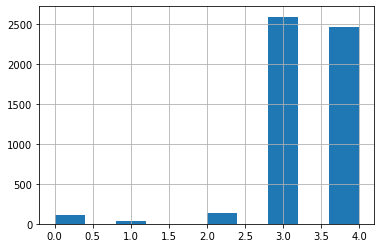

In [0]:
all_records['CoreCount'] = all_records['Biceps brachii'] + all_records['Tibialis anterior'] + all_records['Flexor carpi radialis'] + all_records['Gastrocnemius medial head']
all_records['CoreCount'].hist()

In [0]:
all_records.to_excel('all_records.xlsx')

In [0]:
all_records.to_pickle('all_records.pkl')
patients.to_pickle('all_patients.pkl')

## Ingesting and merging image files

In [0]:
!cp -r /gdrive/*/Thesis_2/april_data/image_tables .

In [0]:
import os

In [0]:
tables = []
for table_path in os.listdir('image_tables'):
  tables.append(pd.read_csv(os.path.join('image_tables',table_path)))

In [0]:
all_images = pd.concat(tables)
# exclude images from records we don't want
all_images = all_images[~all_images['rid'].isin(records_to_exclude)]
all_images['folder_name'] = all_images['rid']

In [0]:
# relabel merged rids
for to_merge, to_keep in merger.items():
  merge_index = all_images.index[all_images['rid'] == to_merge]
  all_images.loc[merge_index,'rid'] = to_keep



In [0]:
all_images['Muscle'] = all_images['Muscle'].apply(sanitize_muscle_name)

In [0]:
all_images.head()

,Muscle,Side,EI,EI_zscore,pid,rid,ImWidth,ImHeight,DeviceInfo,min_h_roi,min_w_roi,max_h_roi,max_w_roi,Image,folder_name
0,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,91.0,428.0,274.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1020...,1251163.20161107.1100
1,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,92.0,428.0,292.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1021...,1251163.20161107.1100
2,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,95.0,428.0,273.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1021...,1251163.20161107.1100
3,Digastricus,L,34.0,-1.7162,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,174.0,144.0,376.0,228.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1012...,1251163.20161107.1100
4,Digastricus,L,34.0,-1.7162,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,198.0,156.0,385.0,237.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1012...,1251163.20161107.1100


In [0]:
len(all_images.groupby(['rid','Muscle']).size())

12639

In [0]:
# all_images = all_images.dropna(subset=['min_h_roi','min_w_roi','max_h_roi','max_w_roi'])

In [0]:
len(all_images.groupby(['rid','Muscle']).size())

12639

In [0]:
all_images = all_images.merge(on='rid',how='left',right=all_records)
all_images.head()

,Muscle,Side_x,EI,EI_zscore,pid_x,rid,ImWidth,ImHeight,DeviceInfo_x,min_h_roi,min_w_roi,max_h_roi,max_w_roi,Image,folder_name,Age,BMI,Class,DeviceInfo_y,EIZ,EIs,Height,Muscles_list,NumberImages,NumberMuscles,NumberZscores,RecordType,RecordTypeId,RecordTypeIdCount,RecordingDate,Sex,Side_y,Sides,Weight,Z_exceed1.0,Z_exceed1.5,Z_exceed2.0,Z_exceed2.5,Z_exceed3.0,Z_exceed3.5,...,Hamstrings,Iliopsoas,Infraspinatus,Intercostals,Interosseus dorsalis I,Levator labii superior,Lingualis,Masseter,Mentalis,Nasalis,Obliquus ext. abdominus,Obliquus int. abdominus,Orbicularis oris,Other,Paraspinaal cervical,Paraspinaal l4,Paraspinaal lumbal,Paraspinaal thoracal,Peroneus longus,Peroneus tertius,Procerus,Quadriceps,Rectus abdominis,Rectus femoris,Rectus femoris prox,Soleus,Sterno cleido,Supraspinatus,Temporalis,Tibialis anterior,Tongue,Transversus abdominus,Trapezius,Triceps,Vastus lateralis,Vastus lateralis dist,Vastus lateralis prox,Vastus medialis,Zygomaticus major,CoreCount
0,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,91.0,428.0,274.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1020...,1251163.20161107.1100,55.2005,32.846606,NaN,ESAOTE_6100,"[2.2817, -1.7162, -2.4347, 0.49661, -1.4085, -...","[90, 34, 28, 54, 55, 53, 36, 50, 42, 41, 100, ...",183.0,"[Biceps brachii, Digastricus, Digastricus, Fle...",80,12,20.0,ALS,68,421,2016-07-11,M,Rechts,"[R, L, R, R, L, R, L, R, L, R, L, R, L, R, L, ...",110.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,4
1,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,92.0,428.0,292.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1021...,1251163.20161107.1100,55.2005,32.846606,NaN,ESAOTE_6100,"[2.2817, -1.7162, -2.4347, 0.49661, -1.4085, -...","[90, 34, 28, 54, 55, 53, 36, 50, 42, 41, 100, ...",183.0,"[Biceps brachii, Digastricus, Digastricus, Fle...",80,12,20.0,ALS,68,421,2016-07-11,M,Rechts,"[R, L, R, R, L, R, L, R, L, R, L, R, L, R, L, ...",110.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,4
2,Biceps brachii,R,90.0,2.2817,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,75.0,95.0,428.0,273.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1021...,1251163.20161107.1100,55.2005,32.846606,NaN,ESAOTE_6100,"[2.2817, -1.7162, -2.4347, 0.49661, -1.4085, -...","[90, 34, 28, 54, 55, 53, 36, 50, 42, 41, 100, ...",183.0,"[Biceps brachii, Digastricus, Digastricus, Fle...",80,12,20.0,ALS,68,421,2016-07-11,M,Rechts,"[R, L, R, R, L, R, L, R, L, R, L, R, L, R, L, ...",110.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,4
3,Digastricus,L,34.0,-1.7162,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,174.0,144.0,376.0,228.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1012...,1251163.20161107.1100,55.2005,32.846606,NaN,ESAOTE_6100,"[2.2817, -1.7162, -2.4347, 0.49661, -1.4085, -...","[90, 34, 28, 54, 55, 53, 36, 50, 42, 41, 100, ...",183.0,"[Biceps brachii, Digastricus, Digastricus, Fle...",80,12,20.0,ALS,68,421,2016-07-11,M,Rechts,"[R, L, R, R, L, R, L, R, L, R, L, R, L, R, L, ...",110.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,4
4,Digastricus,L,34.0,-1.7162,1251163,1251163.20161107.1100,503,480,ESAOTE_6100,198.0,156.0,385.0,237.0,US.1.3.76.2.3.2.90.365914518.3655.7112016.1012...,1251163.20161107.1100,55.2005,32.846606,NaN,ESAOTE_6100,"[2.2817, -1.7162, -2.4347, 0.49661, -1.4085, -...","[90, 34, 28, 54, 55, 53, 36, 50, 42, 41, 100, ...",183.0,"[Biceps brachii, Digastricus, Digastricus, Fle...",80,12,20.0,ALS,68,421,2016-07-11,M,Rechts,"[R, L, R, R, L, R, L, R, L, R, L, R, L, R, L, ...",110.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,4


In [0]:
all_images['ImHeight'].value_counts()

480    70487
661    11434
508      688
413        2
600        1
Name: ImHeight, dtype: int64

In [0]:
all_images.to_pickle('images.pkl')

# Making datasets for export

In [ ]:
patients['DeviceInfo'].value_counts()

In [ ]:
import random
import datetime
from stratifiedSample import stratified_sample

def split_df_strat(df, val_test_size=250, val_size=100):
  total = len(df)
  train_share = 1 - (val_test_size / total)
  print(train_share)
  X_train = stratified_sample(df, strata=['Sex'],size=train_share, seed=3434)
  print(len(X_train))
  remainder = df[~df.index.isin(X_train['index'])]
  val_share = 100 / len(remainder)
  X_val = stratified_sample(remainder, strata=['Sex'], size=val_share, seed=434)
  print(len(X_val))
  X_test = remainder[~remainder.index.isin(X_val['index'])]
  print(len(X_test))
  return X_train, X_val, X_test

def split_df(df, train_share=.8, val_test_prop=.5):
  X_train = df.sample(frac=train_share, random_state=454)
  print(len(X_train))
  remainder = df[~df.index.isin(X_train.index)]
  X_val = remainder.sample(frac=val_test_prop, random_state=353)
  print(len(X_val))
  X_test = remainder[~remainder.index.isin(X_val.index)]
  print(len(X_test))
  return X_train, X_val, X_test

In [ ]:
esaote_sample = patients[(patients['Class'] != 'unknown or uncertain') & (patients['DeviceInfo'] == 'ESAOTE_6100') & (patients['LastRecording'] >= datetime.datetime(2016,5,20)) &(patients['LastRecording'] <= datetime.datetime(2019,5,20))]
esaote_remainder = patients[(patients['Class'] != 'unknown or uncertain') & (patients['DeviceInfo'] == 'ESAOTE_6100') & (~pd.isnull(patients['Class'])) & ~patients.pid.isin(esaote_sample.pid)]
esaote_unlabeled = patients[(~patients.pid.isin(esaote_sample.pid)) & (~patients.pid.isin(esaote_remainder.pid)) & (patients['DeviceInfo'] == 'ESAOTE_6100')]

print(len(esaote_unlabeled))
philips_sample = patients[(patients['Class'] != 'unknown or uncertain') & (patients['DeviceInfo'] == 'Philips Medical Systems_iU22') &(patients['LastRecording'] >= datetime.datetime(2012,1,1)) &(patients['LastRecording'] <= datetime.datetime(2014,12,31))]
philips_remainder = patients[(patients['Class'] != 'unknown or uncertain') & (patients['DeviceInfo'] == 'Philips Medical Systems_iU22') & (~pd.isnull(patients['Class'])) & ~patients.pid.isin(philips_sample.pid)]

philips_unlabeled = patients[(~patients.pid.isin(philips_sample.pid)) & (~patients.pid.isin(philips_remainder.pid)) & (patients['DeviceInfo'] == 'Philips Medical Systems_iU22')]

print(len(philips_unlabeled))

In [ ]:
print(len(philips_unlabeled))
print(philips_unlabeled['Class'].value_counts())

In [ ]:
# get the clean sample ids and sample train and validation set from them
train, val, test = split_df_strat(philips_sample,220,100)
total_train = pd.concat([train, philips_remainder])
print(test['Class'].value_counts(normalize=True))
print(len(total_train))
philips_id_dict = {'train': total_train.pid, 'val': val.pid, 'test': test.pid, 'unlabeled': philips_unlabeled.pid}
print('\n')
train, val, test = split_df_strat(esaote_sample,330,100)
total_train = pd.concat([train, esaote_remainder])
print(test['Class'].value_counts(normalize=True))
print(len(total_train))
esaote_id_dict = {'train': total_train.pid, 'val': val.pid, 'test': test.pid, 'unlabeled': esaote_unlabeled.pid}

# also export the multiple device patients
multiple = patients[(patients['DeviceInfo'] == 'Multiple')]
multiple_id_dict = {'all': multiple.pid}

In [ ]:
import pickle

exporter = {'ESAOTE_6100': esaote_id_dict, 'Philips_iU22': philips_id_dict, 'Multiple': multiple_id_dict}
with open('patient_set_split_final.pkl', 'wb') as f:
  pickle.dump(exporter, f)

base_name = 'devices'
for machine in exporter.keys():
  mapping = exporter[machine]
  for set_name, patients_to_select in mapping.items():
    print(set_name)
    patients_to_select = patients[patients.pid.isin(patients_to_select)]

    print(patients_to_select['Class'].value_counts())
    pids = set(patients_to_select['pid'])
    records_to_select = all_records[all_records['pid'].isin(pids)]
    rids = set(records_to_select['rid'])
    images_to_select = all_images[all_images['rid'].isin(rids)]
    store_path = os.path.join(base_name,machine, set_name)
    os.makedirs(store_path,exist_ok=True)
    patients_to_select.to_pickle(os.path.join(store_path,'patients.pkl'))
    records_to_select.to_pickle(os.path.join(store_path,'records.pkl'))
    images_to_select.to_pickle(os.path.join(store_path,'images.pkl'))

In [ ]:
!zip -r devices.zip devices